# Probmods: Chapter 2

In this notebook I will translate a selection of the example code snippets from the probmods book into Pyro. The original book is written using webPPL, and is available at https://probmods.org/.

First, I'll define a `flip()` function, as this is not built in to Pyro. As we'll see later this cannot be used quite as effortlessly as in webPPl, as there are some additional bookkeeping requirements in Pyro.

In [3]:
import torch
import pyro

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro.infer import Importance, EmpiricalMarginal

import numpy as np
import pandas as pd
import seaborn as sns
import functools

In [6]:
def flip(p=None):
    if p==None: p=.5
    return pyro.sample("coin", dist.Bernoulli(torch.tensor(p)))

In [7]:
flip()

tensor(1.)

webPPL also includes a built-in helper function `viz()` that visualizes probability distributions. We'll have to do this manually

```javascript
// original webPPL code
viz(repeat(1000,flip())
```

<AxesSubplot:ylabel='Count'>

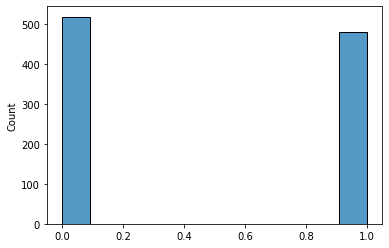

In [17]:
sns.histplot(np.array([flip() for _ in range(1000)]))

In [10]:
flip() + flip() + flip()

tensor(3.)

Next we define a few functions, first `sumFlips()` in webPPL.

```javascript
# original webppl code
var sumFlips = function() { return flip() + flip() + flip() }
viz(repeat(100, sumFlips))
```

<AxesSubplot:ylabel='Count'>

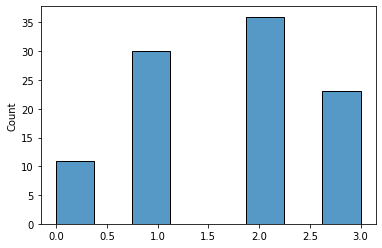

In [52]:
def sumFlips():
    return flip() + flip() + flip()

sns.histplot(np.array([sumFlips() for _ in range(100)]))

```javascript
// original webPPL code
var noisyDouble = function(x) { flip() ? x+x : x }
noisyDouble(3)
```

In [11]:
def noisyDouble(x):
    if flip():
        return x+x
    else:
        return x

noisyDouble(3)

6

```javascript
// original webPPL code
var trickCoin = function() { flip(0.95) ? 'h' : 't' };
viz(repeat(20, trickCoin))
```

<AxesSubplot:ylabel='Count'>

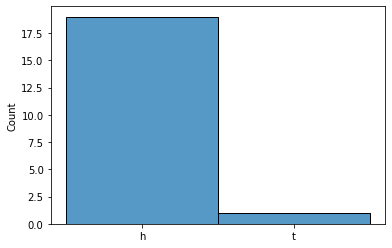

In [12]:
def trickCoin():
    if flip(.95):
        return 'h'
    else:
        return 't'
    
sns.histplot(np.array([trickCoin() for _ in range(20)]))

Ok from here on I will mostly skip including the webPPL code unless it is confusing, interesting, or introduces a new pattern of translation.

<AxesSubplot:ylabel='Count'>

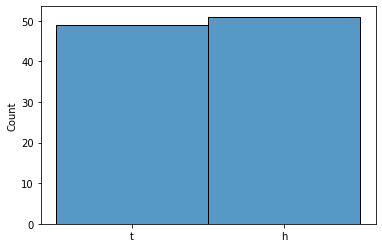

In [90]:
def makeCoin(weight):
    def coin():
        if flip(weight):
            return 'h'
        else:
            return 't'
    return coin

fairCoin = makeCoin(.5)
trickCoin = makeCoin(.95)
bentCoin = makeCoin(.25)

sns.histplot(np.array([fairCoin() for _ in range(100)]))

<AxesSubplot:ylabel='Count'>

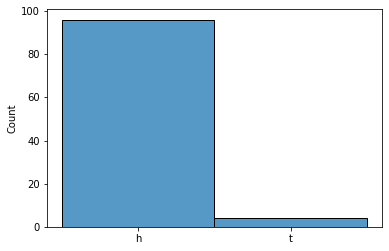

In [84]:
sns.histplot(np.array([trickCoin() for _ in range(100)]))

<AxesSubplot:ylabel='Count'>

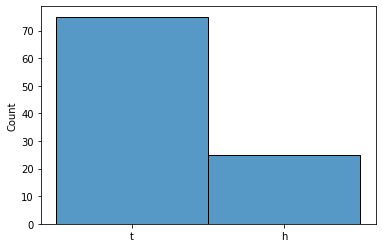

In [85]:
sns.histplot(np.array([bentCoin() for _ in range(100)]))

In [96]:
lungCancer = flip(.01)
cold = flip(.2)
cough = cold or lungCancer
cough

tensor(1.)

In [101]:
lungCancer = flip(.01)
TB= flip(.005)
stomachFlu = flip(.1)
cold = flip(.2)
other = flip(.1)

cough = (cold and flip(.5)) or (lungCancer and flip(.3)) or (TB and flip(.7)) or (other and flip(.01))

fever = (cold and flip(.3)) or (stomachFlu and flip(.5)) or (TB and flip(.1)) or (other and flip(.01))

chestPain = (cold and flip(.5)) or (TB and flip(.5)) or (other and flip(.01))

shortnessOfBreath = (lungCancer and flip(.5)) or (TB and flip(.2)) or (other and flip(.01))

symptoms = {"cough":cough, "fever":fever, "chestPain":chestPain, "shortnessOfBreath":shortnessOfBreath }

symptoms

{'cough': tensor(0.),
 'fever': tensor(1.),
 'chestPain': tensor(0.),
 'shortnessOfBreath': tensor(0.)}

<AxesSubplot:ylabel='Count'>

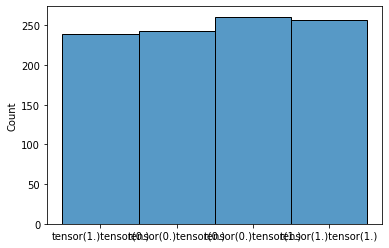

In [119]:
def randomPair():
    return [flip(), flip()]

sns.histplot(np.array([ ''.join(map(str,randomPair())) for _ in range(1000)]))


```javascript
//original webPPL code

//make a distribution using the Bernoulli constructor:
var b = Bernoulli({p: 0.5})

//sample from it with the sample operator:
print( sample(b) )

//compute the log-probability of sampling true:
print( b.score(true) )
```

tensor(1.)
tensor(-0.6931)


<AxesSubplot:xlabel='value', ylabel='prob'>

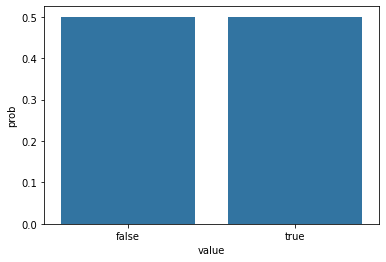

In [48]:
# make distribution
b = dist.Bernoulli(.5)

# sample from it
print(b.sample())

# compute log-probability of sampling true
print(b.log_prob(torch.tensor(1.)))

# visualize the distribution
d = {
    "prob":np.array(torch.exp(b.log_prob(torch.tensor([0.,1.])))), 
    "value":["false", "true"]
    }

sns.barplot(x="value",y="prob", data=pd.DataFrame(data = d), color="tab:blue")

## Constructing marginal distributions: (pyro equivalent to) `Infer`

Here is a big difference worth marking. The inference interface in Pyro is much more capable but also a fair deal more complicated. It is also more difficult to use "simpler" inference approaches: exact enumeration requires some extra syntax and there is no direct implementation of rejection sampling nor is there plain-vanilla Metropolis-Hastings MCMC. Fortunately the implementation of importance sampling seems quite useful for simple low-dimensional models.

```javascript
// original webPPL code
//a complex function, that specifies a complex sampling process:
var foo = function(){gaussian(0,1)*gaussian(0,1)}

//make the marginal distributions on return values explicit:
var d = Infer({method: 'forward', samples: 1000}, foo)

//now we can use d as we would any other distribution:
print( sample(d) )
viz(d)
```

<AxesSubplot:ylabel='Density'>

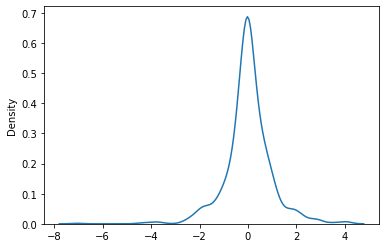

In [14]:
# guidance from this post: https://forum.pyro.ai/t/is-there-an-equivalent-pyro-construct-for-webppls-infer-operator/612/2

def foo():
    a = pyro.sample("a", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    b = pyro.sample("b", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    return a*b

# make the marginal distributions on return values explicit:
posterior = Importance(foo, num_samples=1000)
marginal = EmpiricalMarginal(posterior.run())

samples = [marginal.sample() for _ in range(1000)]
sns.kdeplot(np.array(samples))

## Stochastic recursion

Skipping ahead a bit, we reach a recursive implementation of the geometric distribution. This is our first illustration of the extra bookkeeping needed in Pyro. Here, it means we can't just reuse our `flip()` function inside this recursive function.

```javascript
// original webPPL code
var geometric = function (p) {
    flip(p) ? 0 : 1 + geometric(p);
};
var g = Infer({method: 'forward', samples: 1000},
              function(){return geometric(0.6)})
viz(g)
```

<AxesSubplot:ylabel='Count'>

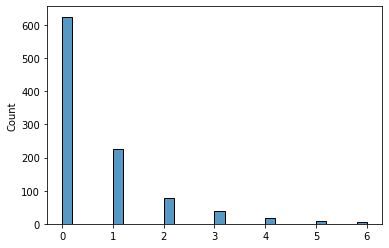

In [15]:
from functools import partial

# this needs a bit of extra book-keeping so we can't just reuse flip() function
# see pyro docs (intro to models)

def geometric(p, t=None):
    if t is None:
        t = 0
    x = pyro.sample("x_{}".format(t), pyro.distributions.Bernoulli(p))
    if x.item() == 1:
        return torch.tensor(0)
    else:
        return 1 + geometric(p, t + 1)

posterior = Importance(partial(geometric, .6), num_samples = 1000)
g = EmpiricalMarginal(posterior.run())

sns.histplot(np.array( [g.sample() for _ in range(1000)]))


## Memoization

If you run the function below, it gives a new result each time. But what we'd really like to do is randomly assign an eye color that persists.

In [16]:
def eyeColor(person):
    n = 3
    labels = ["blue","green","brown"]
    x = dist.Categorical(probs=torch.ones(n)/n).sample()
    return labels[x]

print("suzie's eyes are", eyeColor("suzie"))
print("suzie's eyes are", eyeColor("suzie"))

suzie's eyes are green
suzie's eyes are brown


```javascript
// original webPPL code
var eyeColor = function (person) {
    return uniformDraw(['blue', 'green', 'brown']);
};
[eyeColor('bob'), eyeColor('alice'), eyeColor('bob')];
```

In [211]:
import functools

@functools.lru_cache(maxsize=128)
def eyeColor(person):
    n = 3
    labels = ["blue","green","brown"]
    x = dist.Categorical(probs=torch.ones(n)/n).sample()
    return labels[x]

print("suzie's eyes are", eyeColor("suzie"))
print("suzie's eyes are", eyeColor("suzie"))

suzie's eyes are green
suzie's eyes are green
